# Fish Market Weight Analysis - Regression Modelling

![Alt Text](https://images.unsplash.com/photo-1611214774777-3d997a9d0e35?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8NHx8ZmlzaCUyMG1hcmtldHxlbnwwfHwwfHx8MA%3D%3D&w=1000&q=80)


# Import stuff

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import optuna

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data Loading and Info

In [2]:
df = pd.read_csv('/kaggle/input/fish-market/Fish.csv')

df2 = pd.read_csv('/kaggle/input/fish-market/Fish.csv')

df.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  159 non-null    object 
 1   Weight   159 non-null    float64
 2   Length1  159 non-null    float64
 3   Length2  159 non-null    float64
 4   Length3  159 non-null    float64
 5   Height   159 non-null    float64
 6   Width    159 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB


## Info

* 7 cols, 1 cat, 6 numerical
* Weight as label, 6 features
* no null values, check duplicates?
* unique species? balanced dataset?
* check distribution of numericals

In [4]:
df.describe()

,Weight,Length1,Length2,Length3,Height,Width
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,398.326415,26.247170,28.415723,31.227044,8.970994,4.417486
std,357.978317,9.996441,10.716328,11.610246,4.286208,1.685804
min,0.000000,7.500000,8.400000,8.800000,1.728400,1.047600
25%,120.000000,19.050000,21.000000,23.150000,5.944800,3.385650
50%,273.000000,25.200000,27.300000,29.400000,7.786000,4.248500
75%,650.000000,32.700000,35.500000,39.650000,12.365900,5.584500
max,1650.000000,59.000000,63.400000,68.000000,18.957000,8.142000


## Describe

* Weight min of 0? need to clean
* length mean +- std looks decent, not like the weight data mistake
* same for height and width, guess we have to check and atleast remove the 0 weight

/tmp/ipykernel_20/3155203181.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


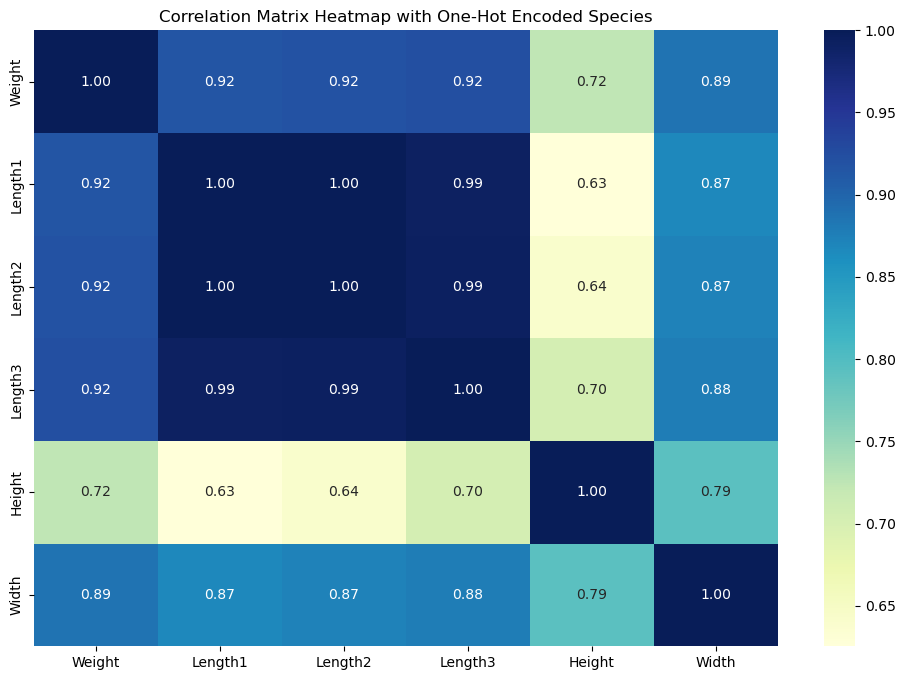

In [5]:
# corr matrix
correlation_matrix = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Correlation Matrix Heatmap with One-Hot Encoded Species")
plt.show()

## corrmatrix

* high corr between different lengths, all fishs seems to have the same shape?
* all numerical features highly correlated with weight, height with the lowest, but still at 0.72
* Bream and Pike highest correlations, heaviest fish, Roach and Smelt large negative, lightest fish

Lets make one per species!

In [6]:
df.groupby('Species').agg({'Weight':'mean'}).sort_values(by = 'Weight')

,Weight
Species,
Smelt,11.178571
Roach,152.050000
Parkki,154.818182
Perch,382.239286
Whitefish,531.000000
Bream,617.828571
Pike,718.705882


Yep, turns out Smelt is by far the lightest and pike the heaviest fish

## Species specific corr matrix

/tmp/ipykernel_20/3347579377.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_species.corr()


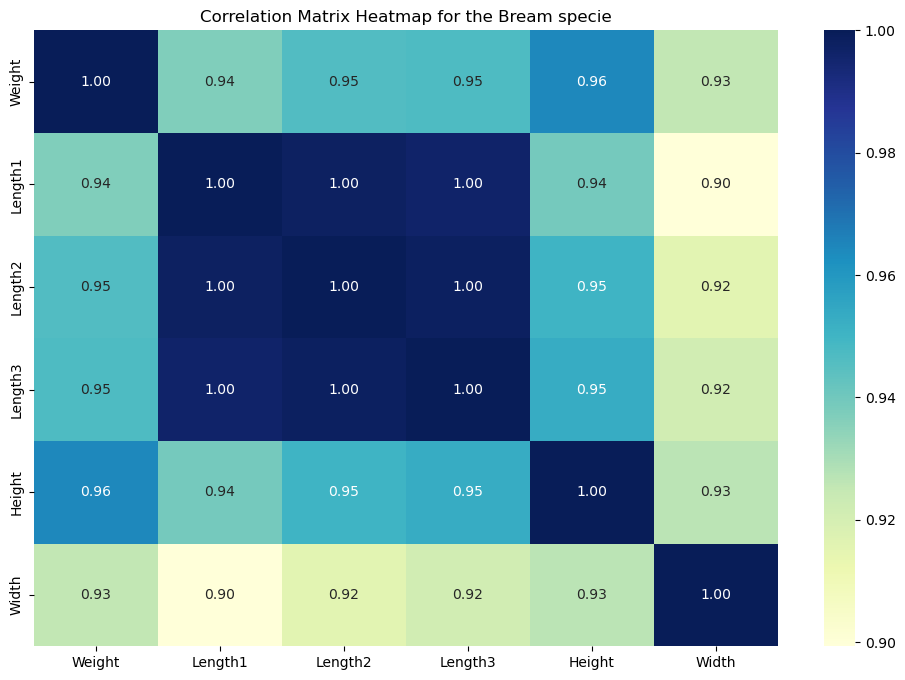

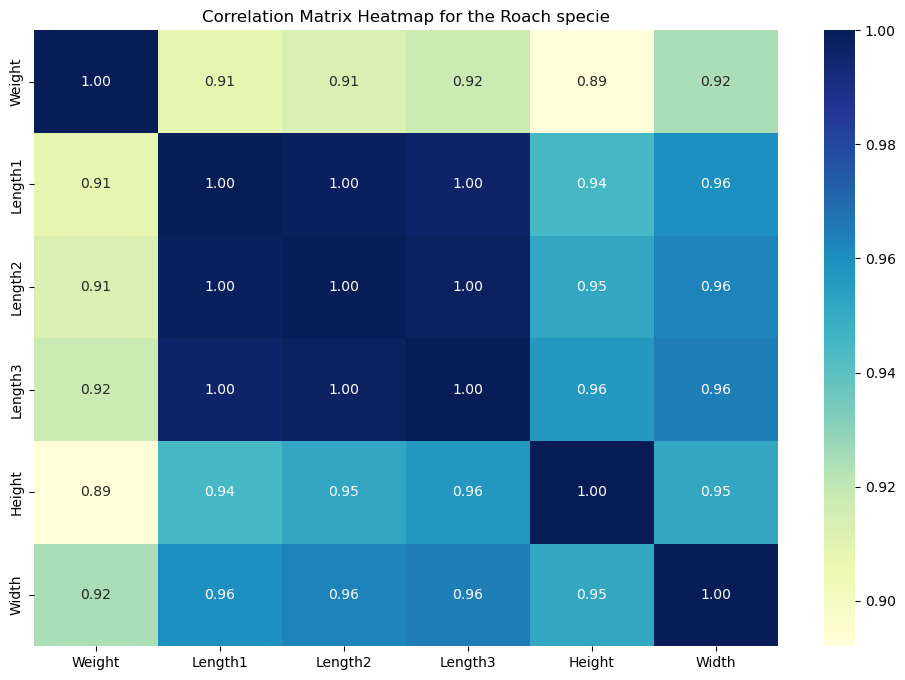

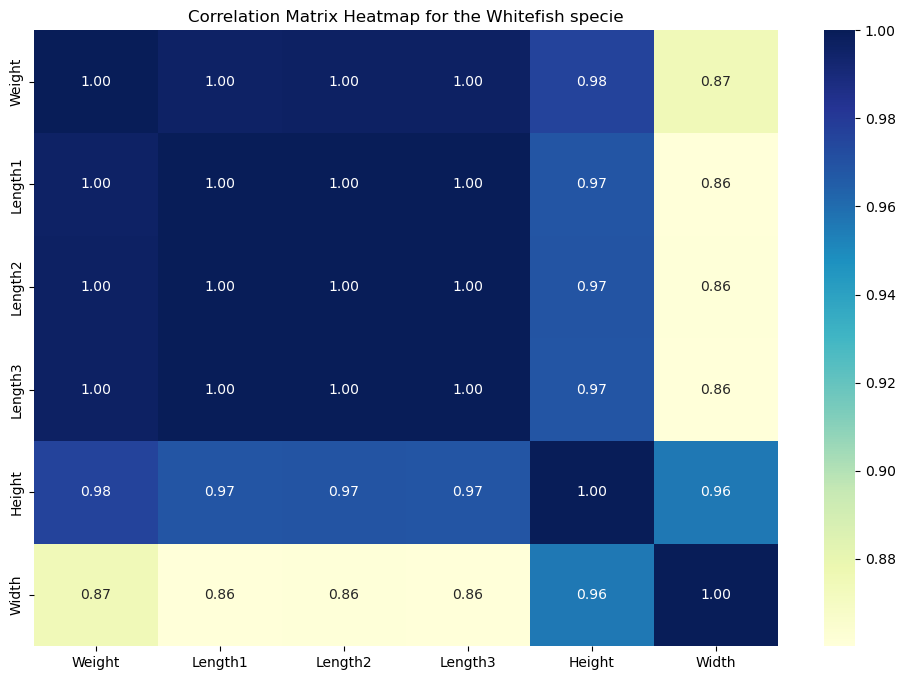

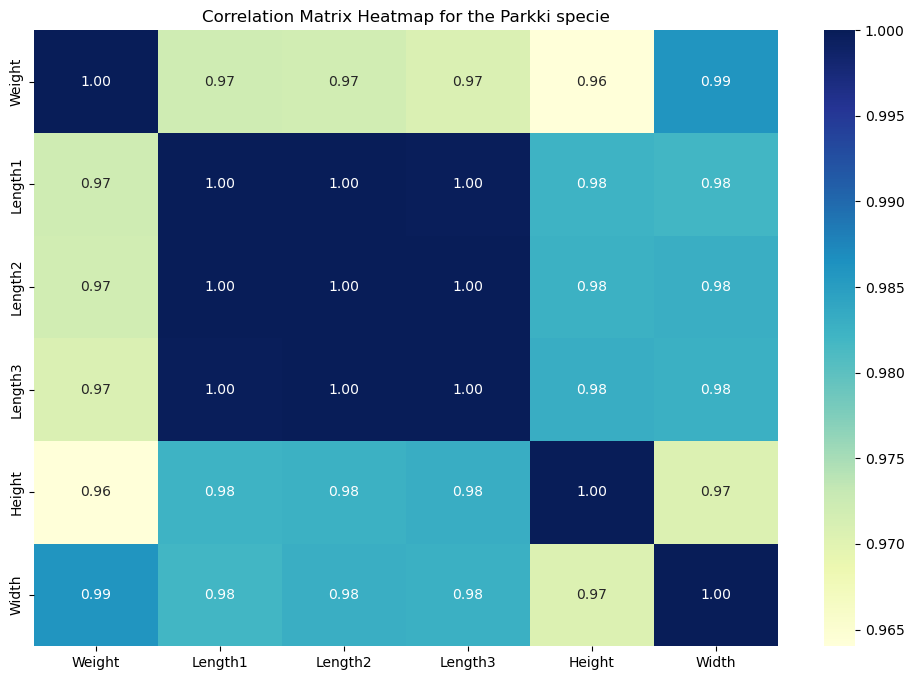

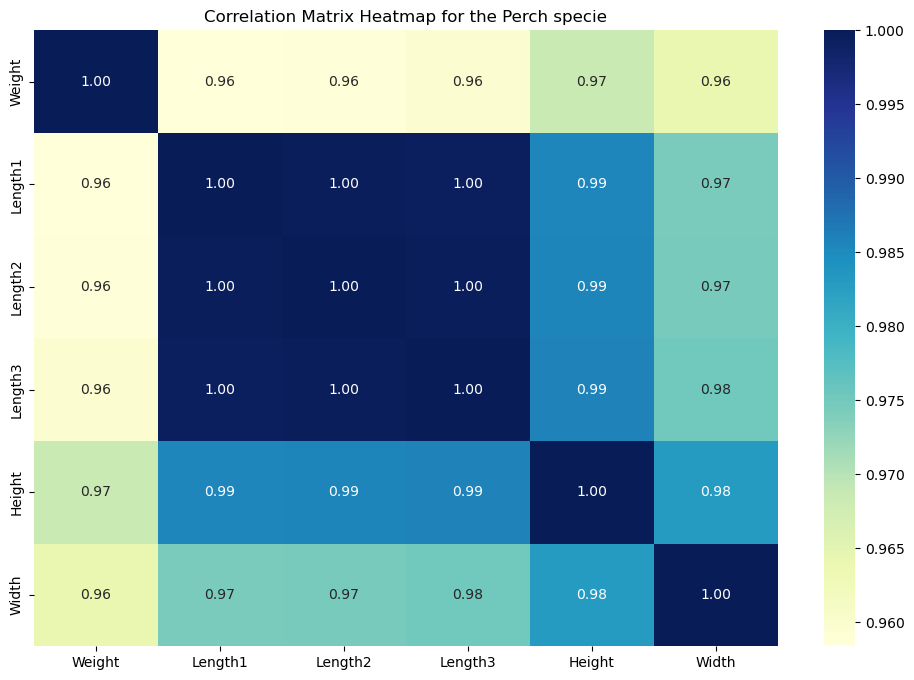

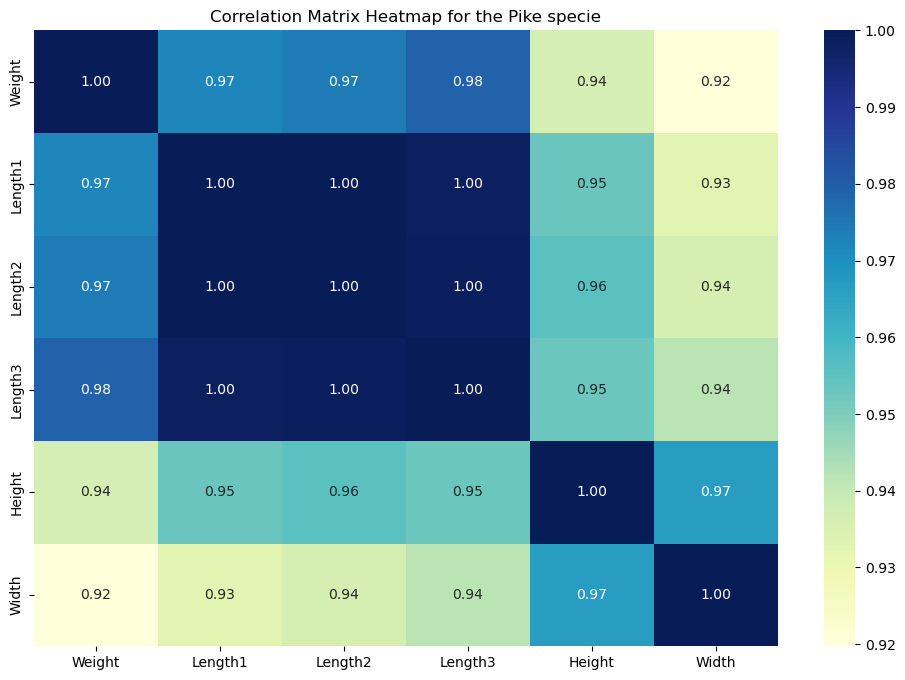

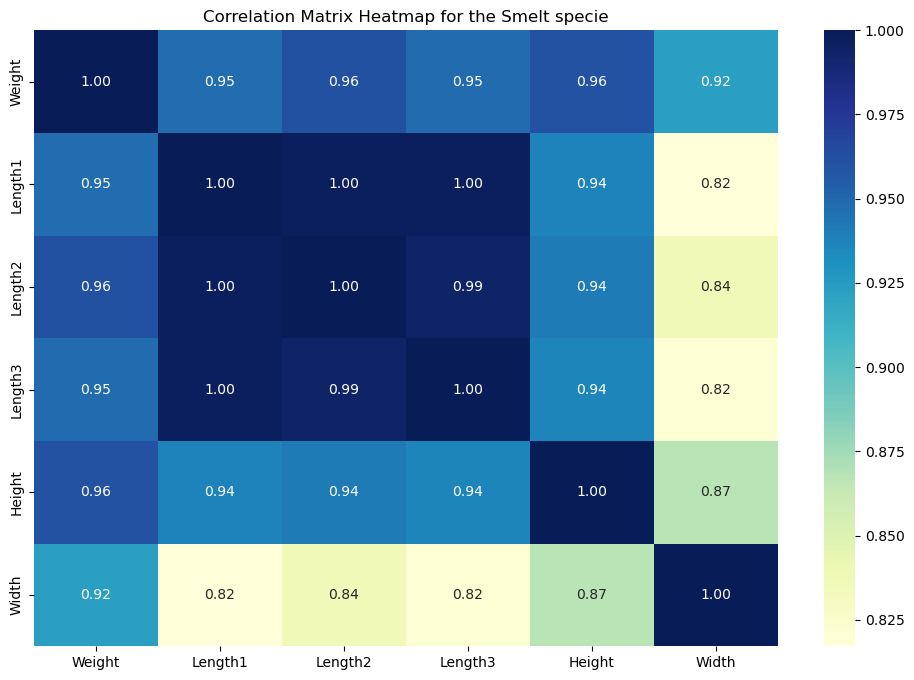

In [7]:
# Create a list of unique species
unique_species = df['Species'].unique()

# Loop through each unique species
for species in unique_species:
    # Filter the dataset for the current species
    df_species = df[df['Species'] == species]
    
    # corr matrix
    correlation_matrix = df_species.corr()

    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title(f"Correlation Matrix Heatmap for the {species} specie")
    plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


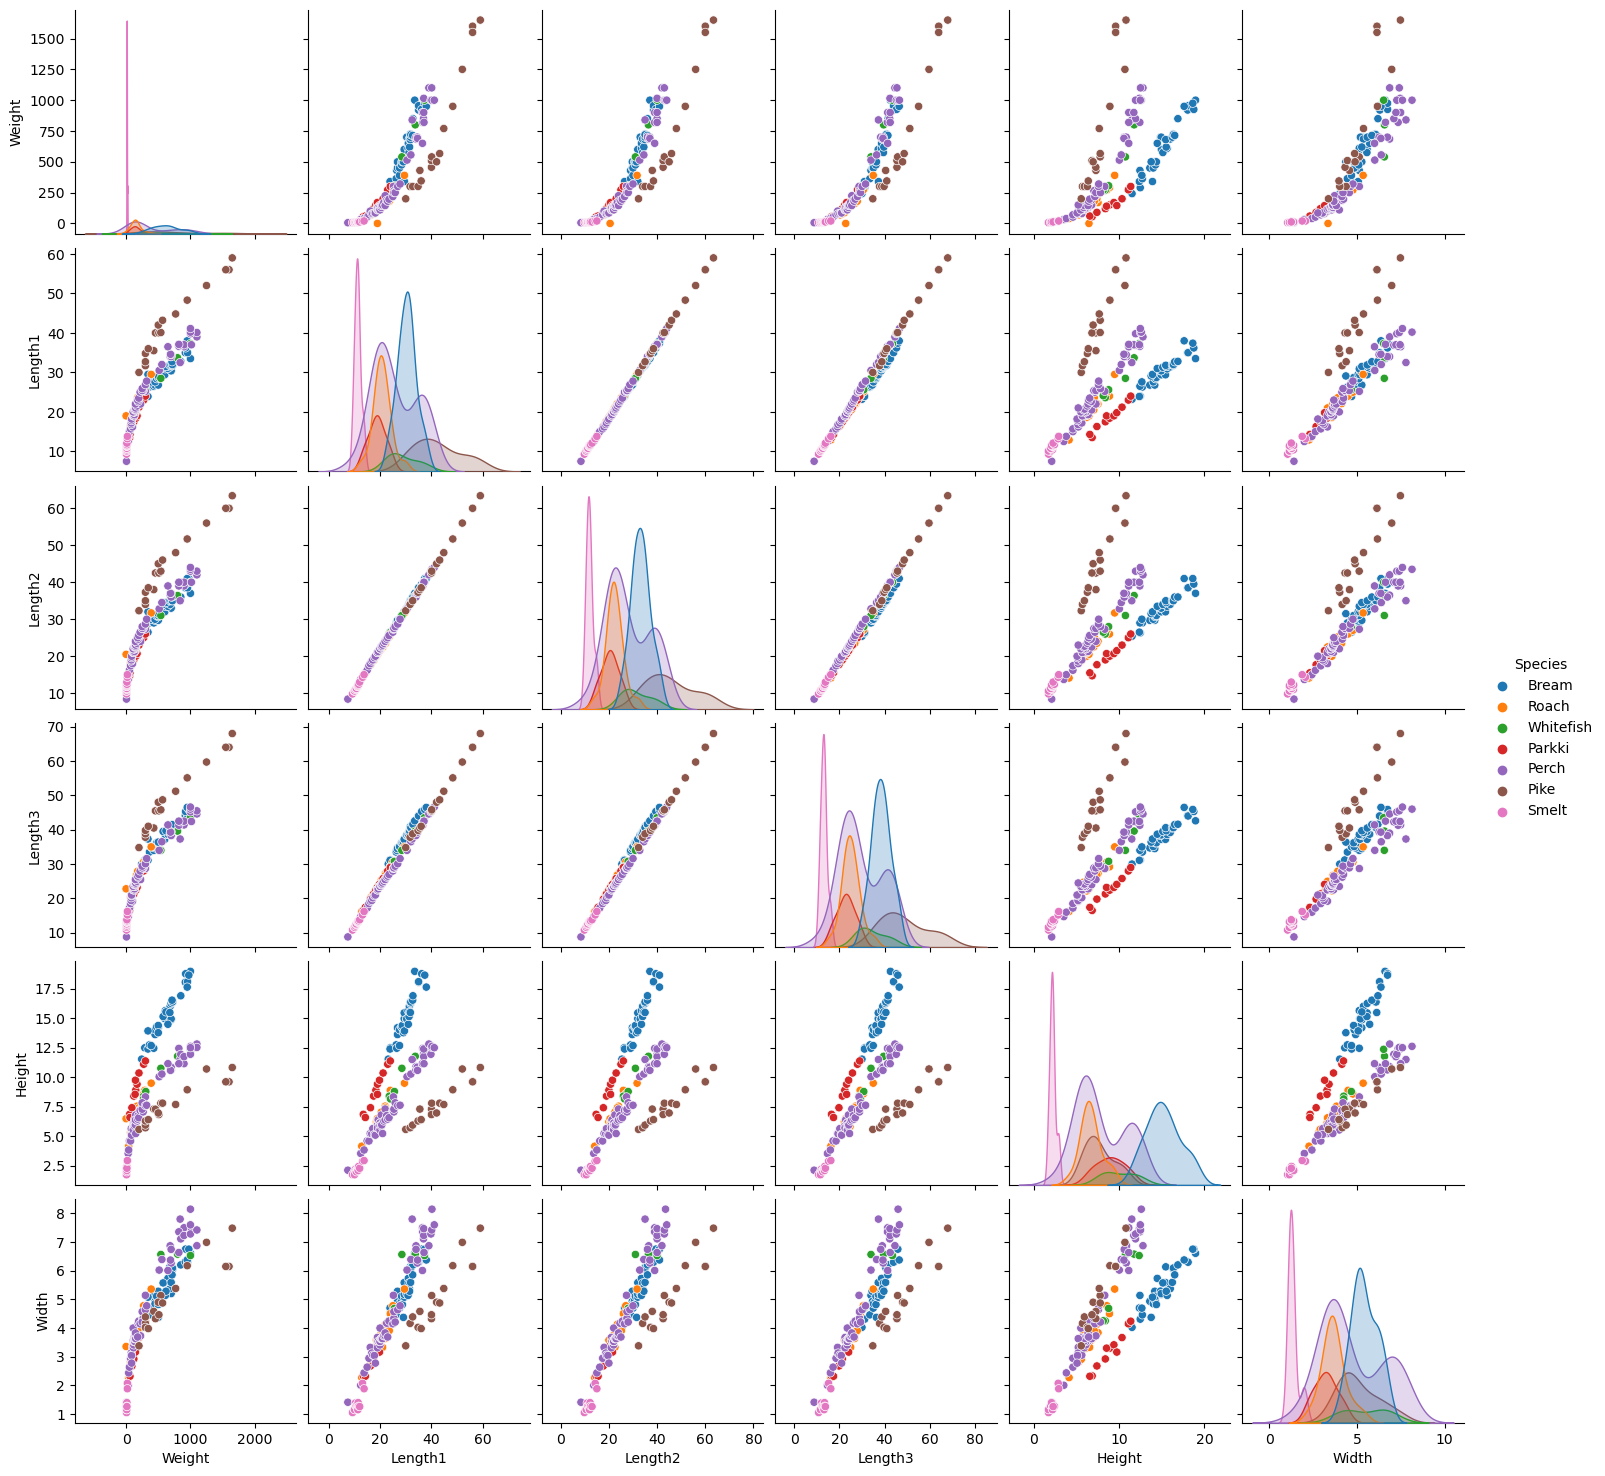

In [8]:
sns.pairplot(data = df , hue = 'Species');

## Pairplot

* multicollinearity, backs up results from corr_matrix
* many strong linear relations, but some non-linear relations, maybe LinearRegression wont be the best model choice, we'll see

# Cleaning + Engi

## Feature Reduction

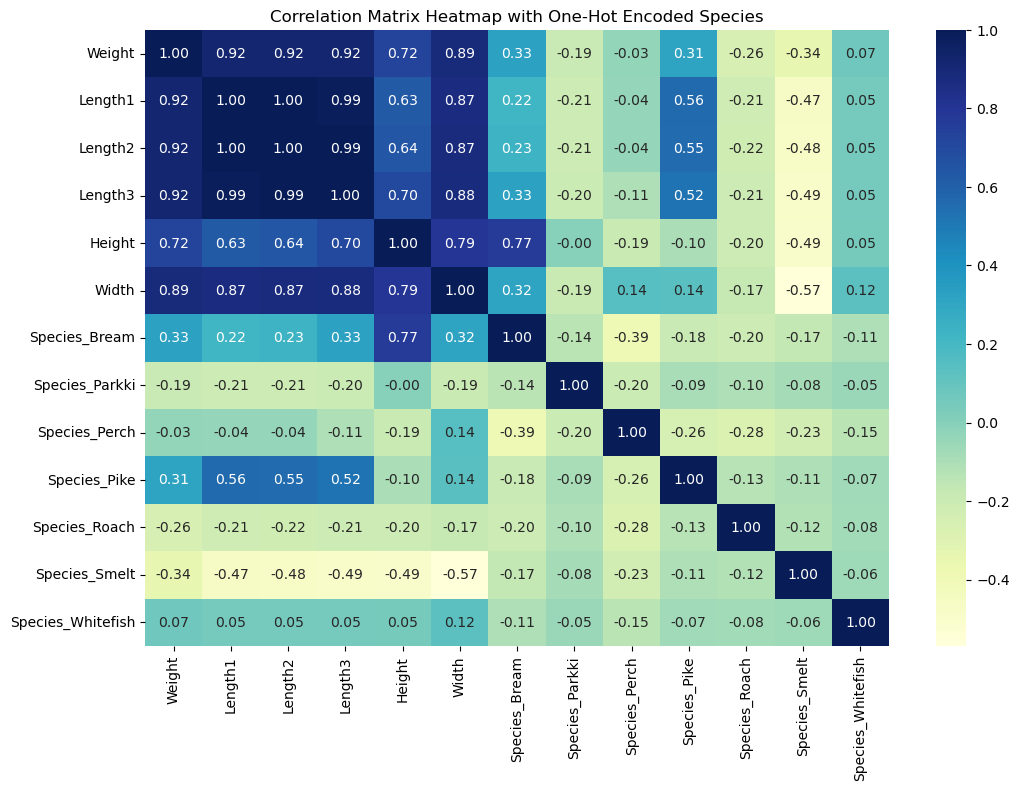

In [9]:
# OHE to show cat feature
df_encoded = pd.get_dummies(df, columns=['Species'], prefix=['Species'])

correlation_matrix = df_encoded.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Correlation Matrix Heatmap with One-Hot Encoded Species")
plt.show()

## Reading data again

In [10]:
# read data from github
df = pd.read_csv('https://raw.githubusercontent.com/Ankit152/Fish-Market/main/Fish.csv')

# find the fish with weight 0
print(df[df['Weight'] == 0])

# remove from the dataset
df = df[df['Weight'] != 0]

# only keep correlated features
df = df[["Weight", "Length1", "Height"]]

df.head()

   Species  Weight  Length1  Length2  Length3  Height   Width
40   Roach     0.0     19.0     20.5     22.8  6.4752  3.3516


,Weight,Length1,Height
0,242.0,23.2,11.5200
1,290.0,24.0,12.4800
2,340.0,23.9,12.3778
3,363.0,26.3,12.7300
4,430.0,26.5,12.4440


/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


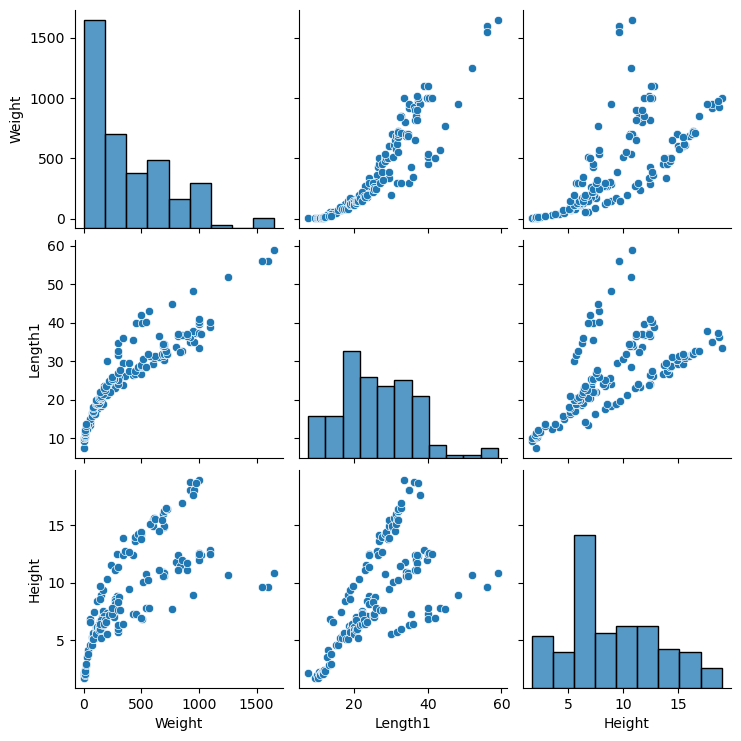

In [11]:
sns.pairplot(data = df)

**We see a exponential growth, lets see if we can improve the correlation**

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Model Output:

Coefficients: [2.03658154 0.98697566]

Intercept: -1.3556627027859176

Mean Squared Error (MSE): 0.004051330892541559

R-squared (R^2): 0.989519117253699

Mean Absolute Error (MAE): 0.05274590393421856



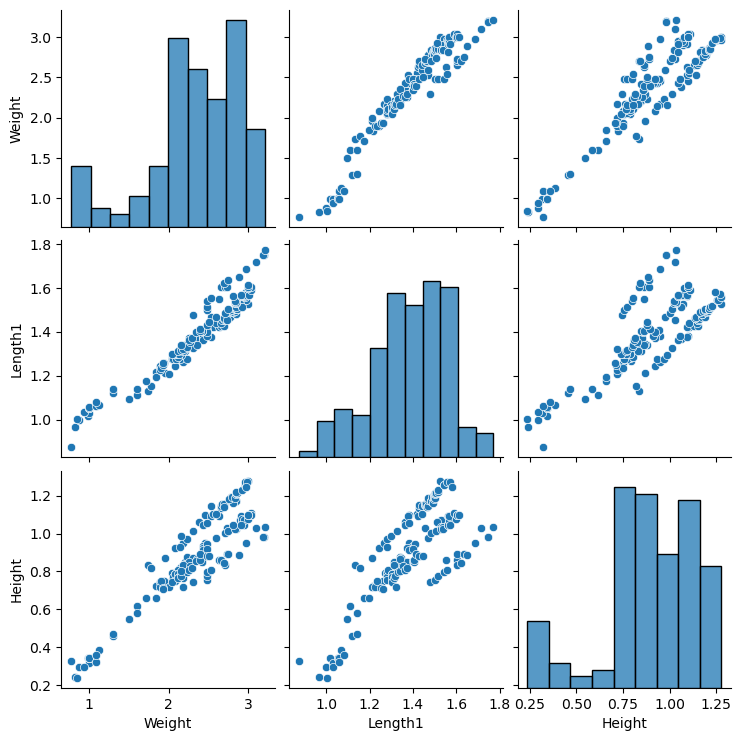

In [12]:
# log transform the columns
df["Length1"] = np.log10(df["Length1"])  # Base 10 logarithm
df["Height"] = np.log10(df["Height"])    # Base 10 logarithm
df["Weight"] = np.log10(df["Weight"])    # Base 10 logarithm

# pairplot
sns.pairplot(data = df)

print('''Model Output:

Coefficients: [2.03658154 0.98697566]

Intercept: -1.3556627027859176

Mean Squared Error (MSE): 0.004051330892541559

R-squared (R^2): 0.989519117253699

Mean Absolute Error (MAE): 0.05274590393421856
''')

**Much better, with a base 10 log we can improve correlation between features and label**

# Model

## Linear Regression

Coefficients: [2.03658154 0.98697566]
          
Intercept: -1.3556627027859176
          
Mean Squared Error (MSE): 4338.964020928945
          
R-squared (R^2): 0.9676777320083878
          
Root Mean Squared Error (RMSE): 65.87081311877776

Formula: Weight = -1.3557 + (2.0366 * Length1) + (0.9870 * Height)



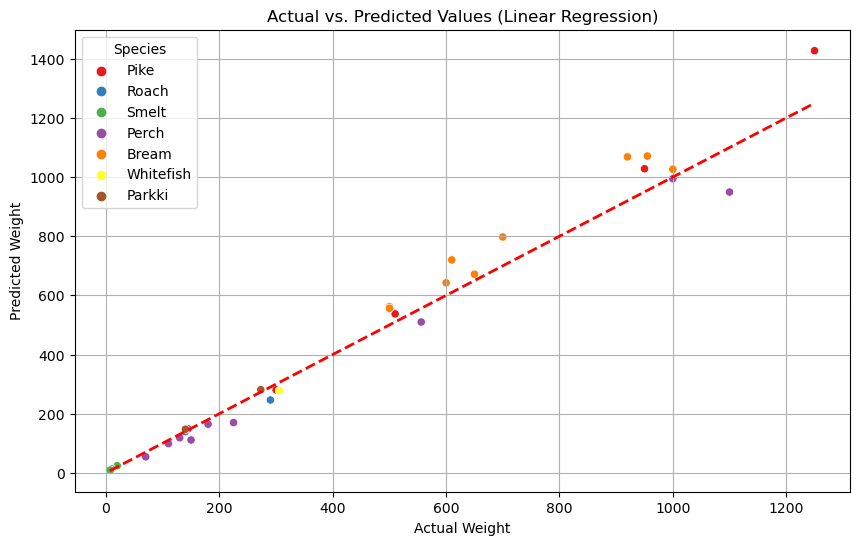

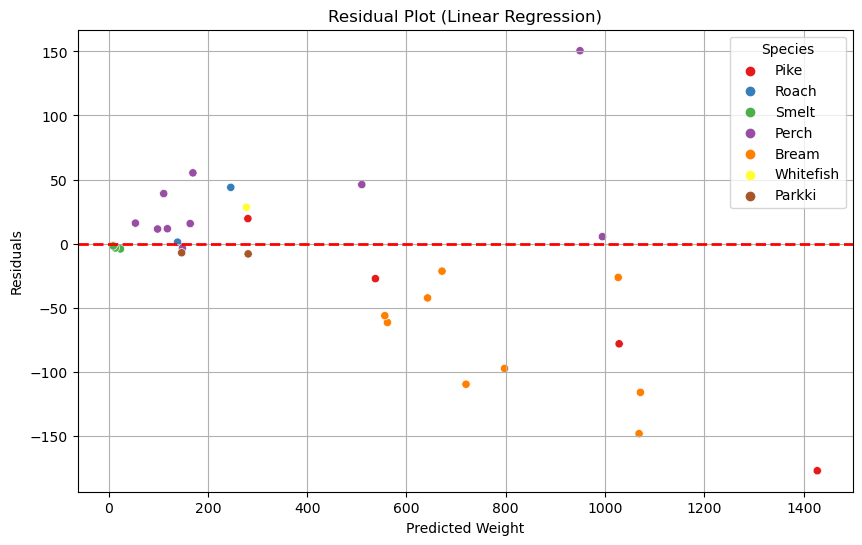

In [13]:
# read data from github
df = pd.read_csv('https://raw.githubusercontent.com/Ankit152/Fish-Market/main/Fish.csv')

# remove from the dataset
df = df[df['Weight'] != 0]

# log transform features and label for model
df[['Weight', 'Length1', 'Height']] = np.log10(df[['Weight', 'Length1', 'Height']])

# label and features
X = df[["Length1", "Height"]]
y = df['Weight']

# split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    shuffle=True, 
                                                    random_state=42)

# fit
lr = LinearRegression()
lr.fit(X_train, y_train)

# predict
y_pred = 10 ** lr.predict(X_test)

y_test = 10 ** y_test 

# coefficients and metrics
print(f'''Coefficients: {lr.coef_}
          \nIntercept: {lr.intercept_}
          \nMean Squared Error (MSE): {mean_squared_error(y_test, y_pred)}
          \nR-squared (R^2): {r2_score(y_test, y_pred)}
          \nRoot Mean Squared Error (RMSE): {mean_squared_error(y_test, y_pred, squared=False)}''')

# Formula for the current species
formula = f'Weight = {lr.intercept_:.4f} + ({lr.coef_[0]:.4f} * Length1) + ({lr.coef_[1]:.4f} * Height)'
print(f'\nFormula: {formula}\n')


# merge species to get seaborn hue
X_test_with_species = X_test.merge(df2[['Species']], left_index=True, right_index=True, how='left')

# scatter
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, hue=X_test_with_species['Species'], palette='Set1')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)
plt.xlabel('Actual Weight')
plt.ylabel('Predicted Weight')
plt.title('Actual vs. Predicted Values (Linear Regression)')
plt.grid(True)
plt.legend(title='Species')
plt.show()

# res plot
plt.figure(figsize=(10, 6))
residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals, hue=X_test_with_species['Species'], palette='Set1')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Weight')
plt.ylabel('Residuals')
plt.title('Residual Plot (Linear Regression)')
plt.grid(True)
plt.legend(title='Species')
plt.show()

**Nice! But there seems to be a tendency for each species in the residuals, perhaps there is a specific relationship between the different species for our features.**

**Lets try to provide the model with species knowledge**

## Species Specific Model

Species: Bream
Coefficients: [1.40776946 1.36471885]
Intercept: -0.9222171742193548
Mean Squared Error (MSE): 5641.301303546202
R-squared (R^2): 0.82582542208893
Root Mean Squared Error (RMSE): 75.10859673530189
Formula: Weight = -0.9222 + (1.4078 * Length1) + (1.3647 * Height)



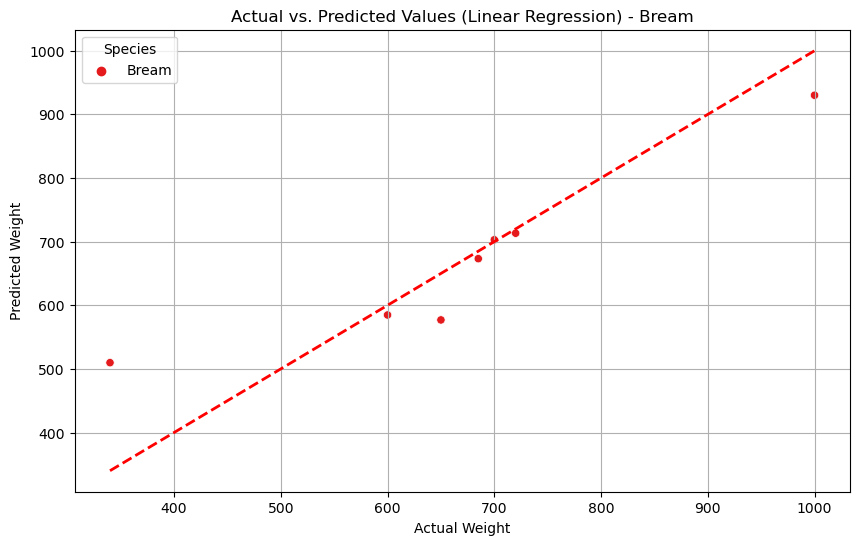

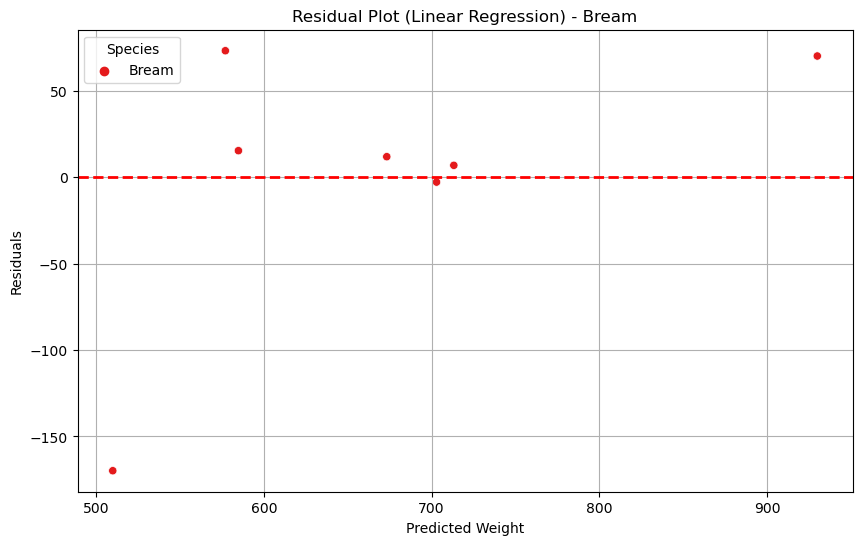

Species: Roach
Coefficients: [1.69080646 1.22064747]
Intercept: -1.0670147394391098
Mean Squared Error (MSE): 90.06622424118459
R-squared (R^2): 0.9557997856682222
Root Mean Squared Error (RMSE): 9.490322662648756
Formula: Weight = -1.0670 + (1.6908 * Length1) + (1.2206 * Height)



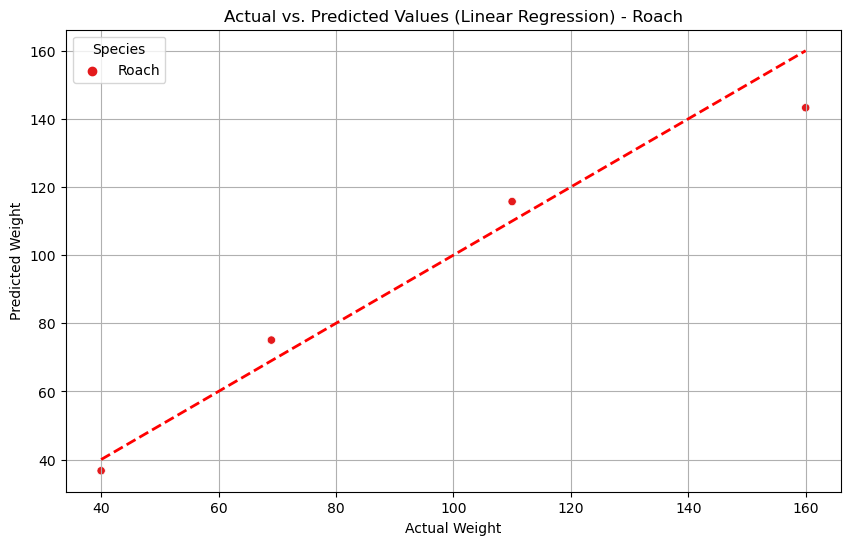

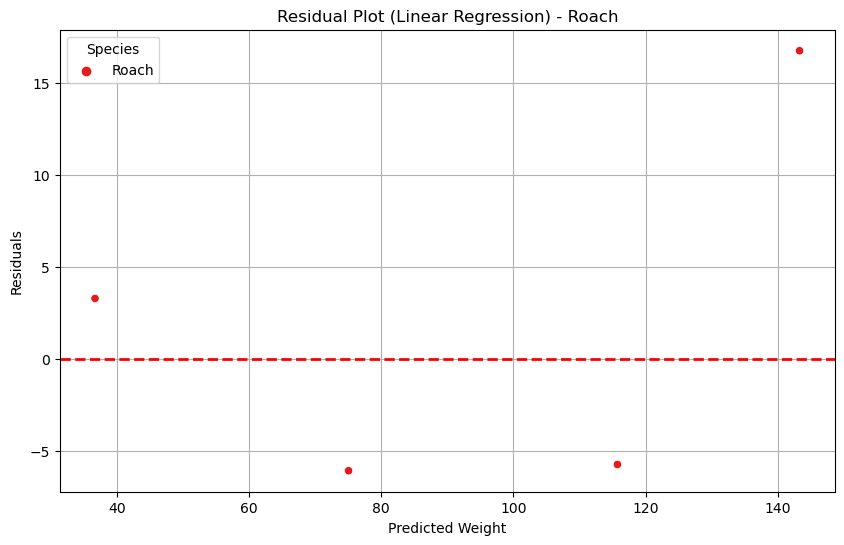

Species: Whitefish
Coefficients: [1.14728846 2.20343387]
Intercept: -1.2086564157736568
Mean Squared Error (MSE): 556.4197346107458
R-squared (R^2): 0.0
Root Mean Squared Error (RMSE): 23.58855092223229
Formula: Weight = -1.2087 + (1.1473 * Length1) + (2.2034 * Height)



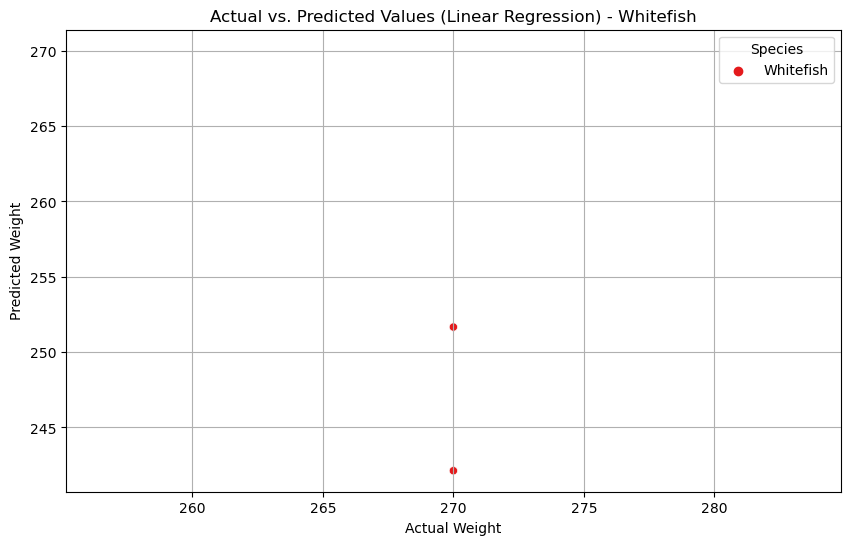

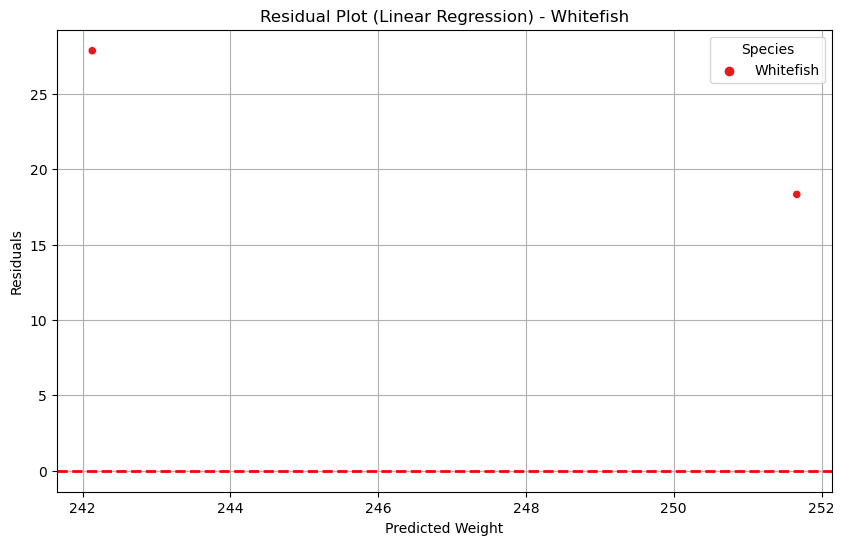

Species: Parkki
Coefficients: [1.94490831 0.98401461]
Intercept: -1.2585483973824
Mean Squared Error (MSE): 44.18952090657578
R-squared (R^2): 0.9945097091559791
Root Mean Squared Error (RMSE): 6.647519906444491
Formula: Weight = -1.2585 + (1.9449 * Length1) + (0.9840 * Height)



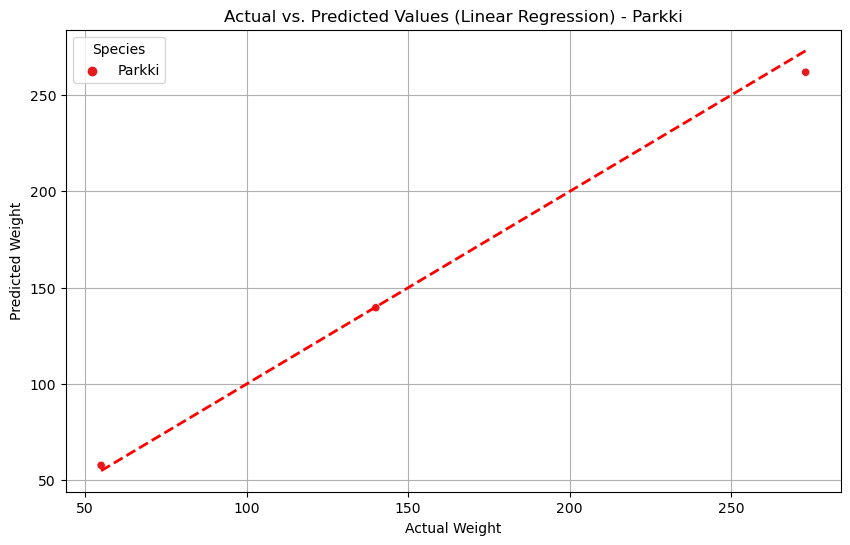

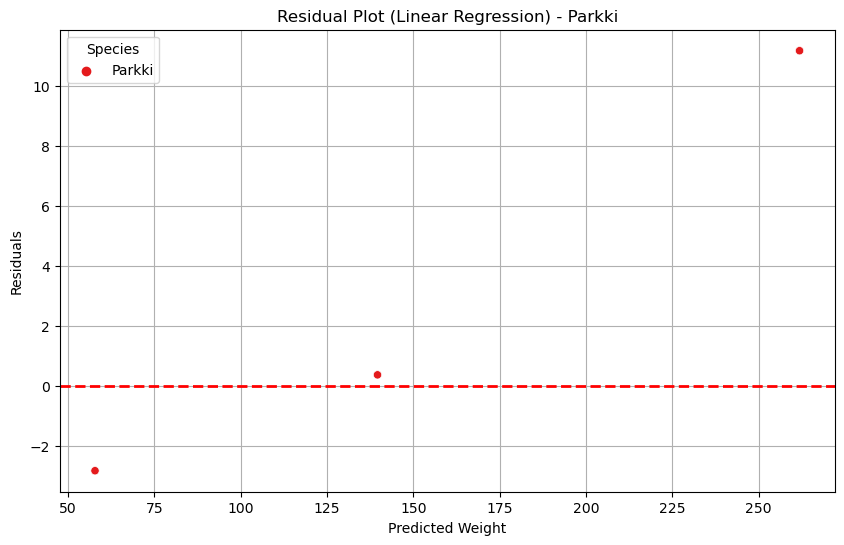

Species: Perch
Coefficients: [1.84117701 1.12470963]
Intercept: -1.1538887297843021
Mean Squared Error (MSE): 1683.6983955784506
R-squared (R^2): 0.9855454617778975
Root Mean Squared Error (RMSE): 41.03289406778969
Formula: Weight = -1.1539 + (1.8412 * Length1) + (1.1247 * Height)



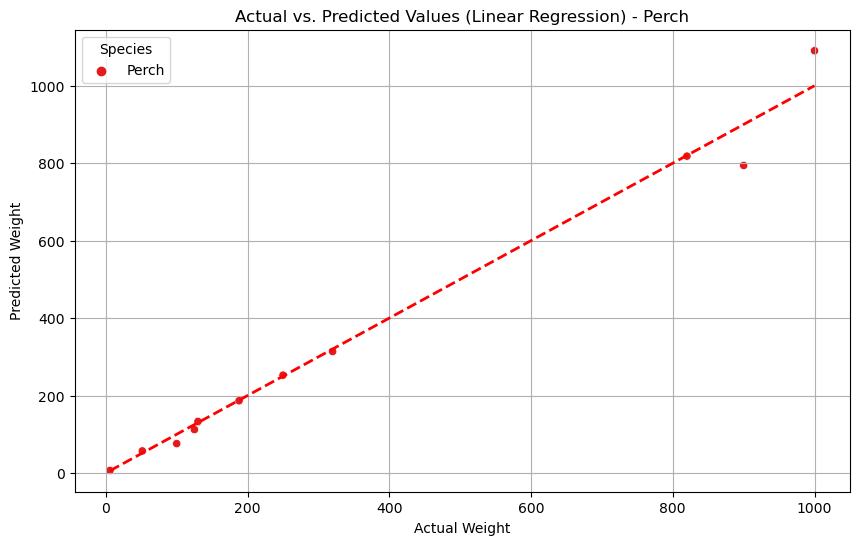

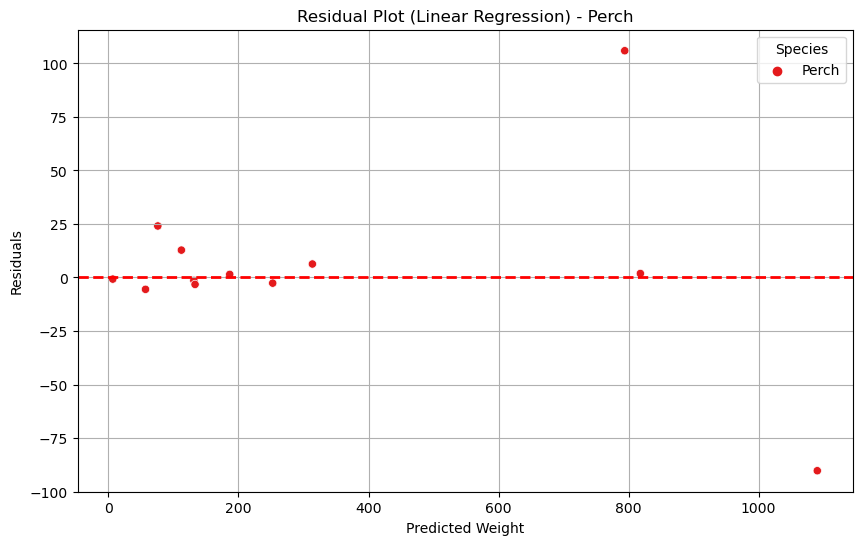

Species: Pike
Coefficients: [2.28156128 0.85085472]
Intercept: -1.6804887278544922
Mean Squared Error (MSE): 7040.427430078679
R-squared (R^2): 0.9768695884804117
Root Mean Squared Error (RMSE): 83.9072549311362
Formula: Weight = -1.6805 + (2.2816 * Length1) + (0.8509 * Height)



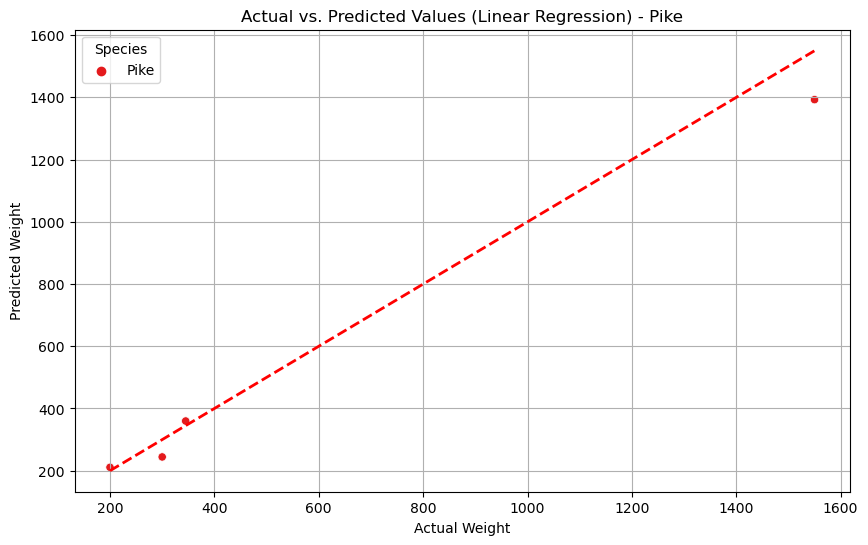

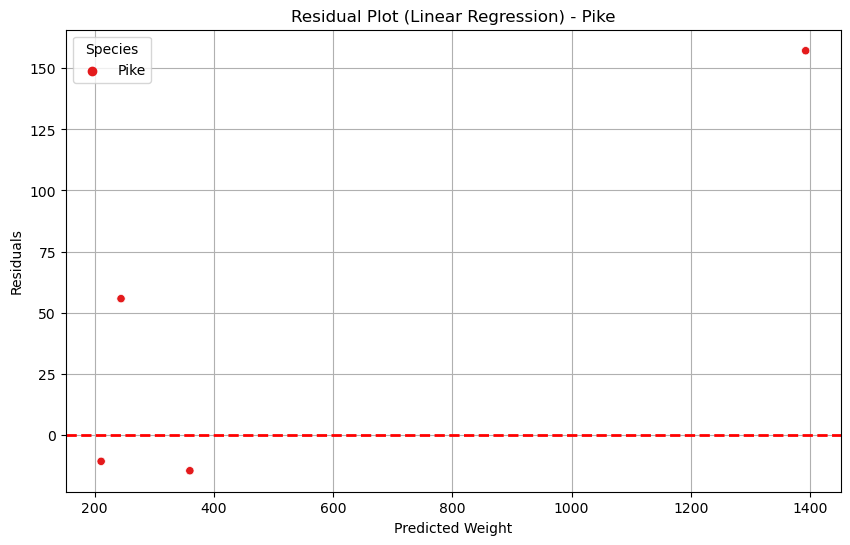

Species: Smelt
Coefficients: [1.16049196 1.44184163]
Intercept: -0.6924186738655498
Mean Squared Error (MSE): 1.7829569450800948
R-squared (R^2): 0.7347667354426304
Root Mean Squared Error (RMSE): 1.3352741085934734
Formula: Weight = -0.6924 + (1.1605 * Length1) + (1.4418 * Height)



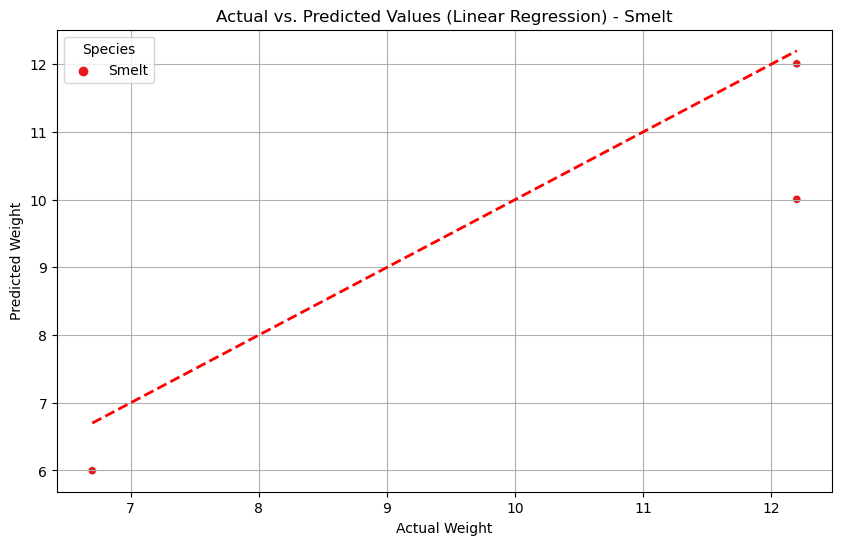

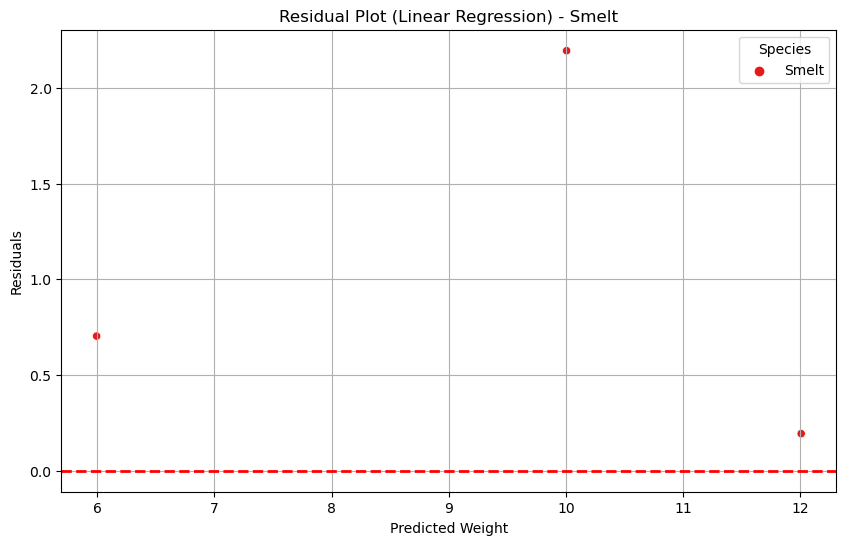

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Read data from GitHub
df = pd.read_csv('https://raw.githubusercontent.com/Ankit152/Fish-Market/main/Fish.csv')

# Remove rows with Weight = 0
df = df[df['Weight'] != 0]

# Log transform features and label for the model
df[['Weight', 'Length1', 'Height']] = np.log10(df[['Weight', 'Length1', 'Height']])

# Create a list of unique species
unique_species = df['Species'].unique()

# Loop through each unique species
for species in unique_species:
    # Filter the dataset for the current species
    df_species = df[df['Species'] == species]
    
    # Label and features for the current species
    X_species = df_species[["Length1", "Height"]]
    y_species = df_species['Weight']
    
    # Split the data for the current species
    X_train_species, X_test_species, y_train_species, y_test_species = train_test_split(X_species, y_species, test_size=0.2, shuffle=True, random_state=42)

    # Fit a linear regression model for the current species
    lr_species = LinearRegression()
    lr_species.fit(X_train_species, y_train_species)

    # Predict for the current species
    y_pred_species = 10 ** lr_species.predict(X_test_species)
    y_test_species = 10 ** y_test_species

    # Coefficients and metrics for the current species
    print(f'Species: {species}')
    print(f'Coefficients: {lr_species.coef_}')
    print(f'Intercept: {lr_species.intercept_}')
    print(f'Mean Squared Error (MSE): {mean_squared_error(y_test_species, y_pred_species)}')
    print(f'R-squared (R^2): {r2_score(y_test_species, y_pred_species)}')
    print(f'Root Mean Squared Error (RMSE): {mean_squared_error(y_test_species, y_pred_species, squared=False)}')
    
    # Formula for the current species
    formula = f'Weight = {lr_species.intercept_:.4f} + ({lr_species.coef_[0]:.4f} * Length1) + ({lr_species.coef_[1]:.4f} * Height)'
    print(f'Formula: {formula}\n')

    # Merge species to get seaborn hue
    X_test_with_species = X_test_species.merge(df[['Species']], left_index=True, right_index=True, how='left')

    # Scatter plot for the current species
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test_species, y=y_pred_species, hue=X_test_with_species['Species'], palette='Set1')
    plt.plot([min(y_test_species), max(y_test_species)], [min(y_test_species), max(y_test_species)], linestyle='--', color='red', linewidth=2)
    plt.xlabel('Actual Weight')
    plt.ylabel('Predicted Weight')
    plt.title(f'Actual vs. Predicted Values (Linear Regression) - {species}')
    plt.grid(True)
    plt.legend(title='Species')
    plt.show()

    # Residual plot for the current species
    plt.figure(figsize=(10, 6))
    residuals_species = y_test_species - y_pred_species
    sns.scatterplot(x=y_pred_species, y=residuals_species, hue=X_test_with_species['Species'], palette='Set1')
    plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
    plt.xlabel('Predicted Weight')
    plt.ylabel('Residuals')
    plt.title(f'Residual Plot (Linear Regression) - {species}')
    plt.grid(True)
    plt.legend(title='Species')
    plt.show()


# Conclusion

## Single Model

Only using Height and Length1 and doing some simple log transformations, a linear regression model can achieve 98.9% R2 score!

If we add the species information, we just to an impressive 99.6% accuracy!

On average a fisherman spends 30 seconds to 1 min measuring a fish, with this approach we can optimize time to more than 50%, allowing fishermen to spend less time with measuring tasks

This will allow fishermen to only measure two things, length and height, and still estimate the weight of the fish with 99% accuracy

## Species Specific Model

We see some great fits but also some bad fits, perhaps because of little data, perhaps more data can improve those species.

Additionally we have a formula for each fish based on its features that the fishermen can use.